# Unsupervised and Supervised Models for Classifying BBC Articles.
 __By John Kostas__
 <br> 

## Introduction
The goal of this project is to classify different articles from the BBC into five different categories. In order to do this I will perform basic EDA
and data cleaning, clean the words through basic retreival and text mining, and quantify the relevant words in each article. I will then train a series of models that will be used to predict the category for each article. Given that we already have labeled data this approach seems like it would be best accomplished using supervised algorithms, however, I will attempt to find latent factors using Non-negative Matrix Factorization.

In [1848]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

import itertools
from collections import defaultdict
import collections
from sklearn.metrics import accuracy_score
from itertools import permutations
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jkost\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jkost\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jkost\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1662]:
#filepaths
train = pd.read_csv('BBC News Train.csv')
test = pd.read_csv('BBC News Test.csv')

# 1. Exploratory Data Analysis

In [1372]:
#Get an idea of what the data looks like.
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [1374]:
train.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [1377]:
print(train['Category'].value_counts())

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


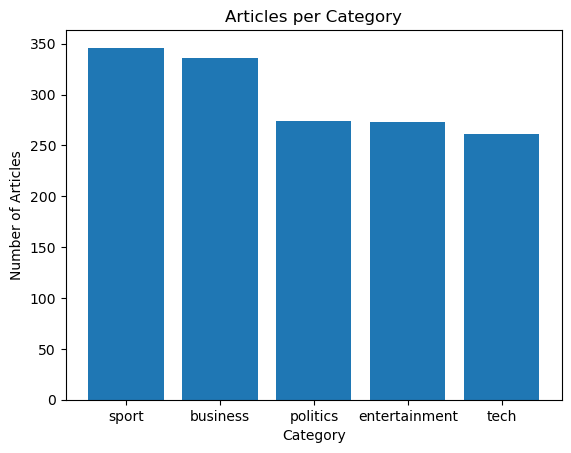

In [1379]:
train['Category'].unique()

fig, ax = plt.subplots()



ax.bar(train['Category'].value_counts().index, train['Category'].value_counts())

ax.set_ylabel('Number of Articles')
ax.set_xlabel('Category')
ax.set_title('Articles per Category')

plt.show()

301


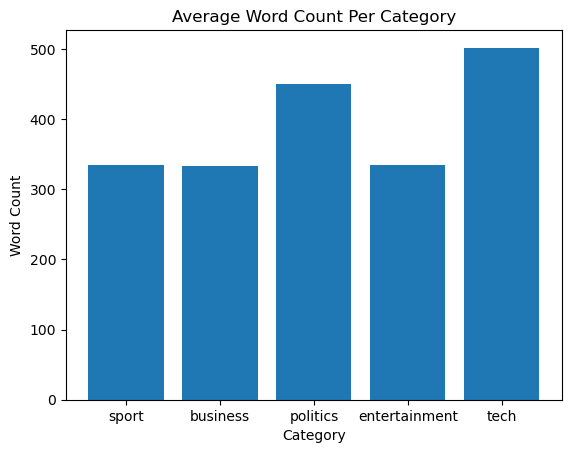

In [1380]:
print(len(train['Text'][0].split()))

df = train.groupby('Category').Text.apply(lambda x: x.str.split().str.len().mean())

fig, ax = plt.subplots()

ax.bar(train['Category'].value_counts().index, df)

ax.set_ylabel('Word Count')
ax.set_xlabel('Category')
ax.set_title('Average Word Count Per Category')

plt.show()

I noticed there were some duplicates earlier, so I will confirm that these duplicates are in the same categories, (ie. not any articles in multiple categories) then drop these rows.

In [1382]:
print(train['Text'].duplicated().sum())
print(train.duplicated(subset = ['Text','Category']).sum())

50
50


All the duplicates are in the same category so I will drop these rows. Ideally I would have done this at the beginning of EDA, but in this case I wanted to confirm the articles were not considered to be multiple categories by BBC.

In [1383]:
train = train.drop_duplicates(subset=['Text'])
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1440 non-null   int64 
 1   Text       1440 non-null   object
 2   Category   1440 non-null   object
dtypes: int64(1), object(2)
memory usage: 45.0+ KB


I am going to split up the data now. I will perform model training on 85% of the data, then use the remaning 15% of the data to evaluate and fine-tune the models. I will reserve the test data for the very end when evaluating performance of different models.

In [1387]:

X_train, y_train, X_test = train, train['Category'].values, test['Text'].values
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.15, random_state=0)
print(X_train_.info())
X_val_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1224 entries, 1206 to 694
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1224 non-null   int64 
 1   Text       1224 non-null   object
 2   Category   1224 non-null   object
dtypes: int64(1), object(2)
memory usage: 38.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 216 entries, 34 to 1233
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  216 non-null    int64 
 1   Text       216 non-null    object
 2   Category   216 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.8+ KB


I will start off by looking at what one of the files looks like.

In [1389]:
print(X_train_['Text'][0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

# 2. NLP/Word Embedding
This step will require four substeps in order to get the data ready for model training and tuning. Given that I am working with articles, I need a process to get rid of unneccesary characters, remove unnecessary words, make words more uniform, and determine what words are important to keep.
## Preprocessing
#### Removing unnecessary punctuation.
Get rid of any punctuation as this will not help with grouping the documents. It could be argued that exclamation and question marks could be useful, but for now we will just focus on the words.
#### Stop word removal
There are a number of words that are very common and don't provide any details or hints on what a document is about. Words like 'a' 'the' 'is' etc. are examples of stop words. These must be removed to get to the "core" of what the document is about.
#### Lemmatization
Lemmatization will remove any a prefix and suffix from a word then convert it to its dictionary word. The idea is to get the "root" of the word. For example reading and rereading would both convert to read.
## TF-IDF
This acronym stands for Term Frequency- Inverse Document Frequency. This will quantify words in documents and compute a score to determine that word's significance in the entire dataset. TF is just the number of certain terms in a document. Words that are in every document will not necessary be useful, neither will words that are only in one document. This is were IDF comes in. IDF shows how rare that specific word is across all documents. It is possible to play around with these parameters in order to better fit data.

In [1391]:
def preprocess (dataframe):
    dataframe['Text'] = dataframe['Text'].replace(r'[^\w\s]', '', regex=True)
    dataframe['Text'] = dataframe['Text'].str.lower()
    dataframe['Text'] = dataframe['Text'].apply(lambda x: x.replace('  ', ' '))
    dataframe['Text'] = dataframe['Text'].apply(lambda x: re.sub(r'\d+','',x))
    dataframe['Text'] = dataframe['Text'].apply(lambda x: nltk.word_tokenize(x))

    #remove stopwords
    

In [1393]:
copy = X_train_.copy()
preprocess(copy)

print(copy['Text'][0])

['worldcom', 'exboss', 'launches', 'defence', 'lawyers', 'defending', 'former', 'worldcom', 'chief', 'bernie', 'ebbers', 'against', 'a', 'battery', 'of', 'fraud', 'charges', 'have', 'called', 'a', 'company', 'whistleblower', 'as', 'their', 'first', 'witness', 'cynthia', 'cooper', 'worldcom', 's', 'exhead', 'of', 'internal', 'accounting', 'alerted', 'directors', 'to', 'irregular', 'accounting', 'practices', 'at', 'the', 'us', 'telecoms', 'giant', 'in', 'her', 'warnings', 'led', 'to', 'the', 'collapse', 'of', 'the', 'firm', 'following', 'the', 'discovery', 'of', 'an', 'bn', 'bn', 'accounting', 'fraud', 'mr', 'ebbers', 'has', 'pleaded', 'not', 'guilty', 'to', 'charges', 'of', 'fraud', 'and', 'conspiracy', 'prosecution', 'lawyers', 'have', 'argued', 'that', 'mr', 'ebbers', 'orchestrated', 'a', 'series', 'of', 'accounting', 'tricks', 'at', 'worldcom', 'ordering', 'employees', 'to', 'hide', 'expenses', 'and', 'inflate', 'revenues', 'to', 'meet', 'wall', 'street', 'earnings', 'estimates', 'bu

In [1395]:
def removeStopwords(dataframe):
    stop_words = set(stopwords.words('english'))
    dataframe['Text'] = dataframe['Text'].apply(lambda x: [word for word in x if word not in stop_words])

In [1397]:
removeStopwords(copy)

print(copy['Text'][0])

['worldcom', 'exboss', 'launches', 'defence', 'lawyers', 'defending', 'former', 'worldcom', 'chief', 'bernie', 'ebbers', 'battery', 'fraud', 'charges', 'called', 'company', 'whistleblower', 'first', 'witness', 'cynthia', 'cooper', 'worldcom', 'exhead', 'internal', 'accounting', 'alerted', 'directors', 'irregular', 'accounting', 'practices', 'us', 'telecoms', 'giant', 'warnings', 'led', 'collapse', 'firm', 'following', 'discovery', 'bn', 'bn', 'accounting', 'fraud', 'mr', 'ebbers', 'pleaded', 'guilty', 'charges', 'fraud', 'conspiracy', 'prosecution', 'lawyers', 'argued', 'mr', 'ebbers', 'orchestrated', 'series', 'accounting', 'tricks', 'worldcom', 'ordering', 'employees', 'hide', 'expenses', 'inflate', 'revenues', 'meet', 'wall', 'street', 'earnings', 'estimates', 'ms', 'cooper', 'runs', 'consulting', 'business', 'told', 'jury', 'new', 'york', 'wednesday', 'external', 'auditors', 'arthur', 'andersen', 'approved', 'worldcom', 'accounting', 'early', 'said', 'andersen', 'given', 'green', '

In [1399]:
def lemmat(dataframe):
    lemmatizer = nltk.WordNetLemmatizer()
    dataframe['Text'] = dataframe['Text'].apply(lambda x: [lemmatizer.lemmatize(single) for single in x ])

In [1401]:
lemmat(copy)
print(copy['Text'][0])

['worldcom', 'exboss', 'launch', 'defence', 'lawyer', 'defending', 'former', 'worldcom', 'chief', 'bernie', 'ebbers', 'battery', 'fraud', 'charge', 'called', 'company', 'whistleblower', 'first', 'witness', 'cynthia', 'cooper', 'worldcom', 'exhead', 'internal', 'accounting', 'alerted', 'director', 'irregular', 'accounting', 'practice', 'u', 'telecom', 'giant', 'warning', 'led', 'collapse', 'firm', 'following', 'discovery', 'bn', 'bn', 'accounting', 'fraud', 'mr', 'ebbers', 'pleaded', 'guilty', 'charge', 'fraud', 'conspiracy', 'prosecution', 'lawyer', 'argued', 'mr', 'ebbers', 'orchestrated', 'series', 'accounting', 'trick', 'worldcom', 'ordering', 'employee', 'hide', 'expense', 'inflate', 'revenue', 'meet', 'wall', 'street', 'earnings', 'estimate', 'm', 'cooper', 'run', 'consulting', 'business', 'told', 'jury', 'new', 'york', 'wednesday', 'external', 'auditor', 'arthur', 'andersen', 'approved', 'worldcom', 'accounting', 'early', 'said', 'andersen', 'given', 'green', 'light', 'procedure'

In [1403]:
print(copy.groupby('Category').Text.apply(lambda x: x.str.len().min()))
print(copy.groupby('Category').Text.apply(lambda x: x.str.len().max()))
print(copy.groupby('Category').Text.apply(lambda x: x.str.len().mean()))

Category
business          80
entertainment     88
politics          47
sport             61
tech             104
Name: Text, dtype: int64
Category
business          505
entertainment    1230
politics         1632
sport             911
tech              829
Name: Text, dtype: int64
Category
business         191.291525
entertainment    190.423256
politics         250.191964
sport            180.584459
tech             284.432990
Name: Text, dtype: float64


In [1588]:
#Helper function 
def label_permute_compare(ytdf,yp,n=5):
    yp = np.array([np.argmax(i) for i in yp])
    y_true = np.array(ytdf).reshape(-1)
    uniq_labels = np.unique(y_true)
    perm = itertools.permutations(range(len(uniq_labels)))
    best_permutation = None 
    best_accuracy = 0
    for p in perm:
        p_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
        p_labels = np.array([p_label_map[label] for label in y_true])
        acc = np.mean(p_labels == yp)
        if acc > best_accuracy:
            best_permutation = {num: l for num, l in zip(p, uniq_labels)}
            best_accuracy = acc
    return best_accuracy, best_permutation

    
    

In [1590]:
def identity_tokenizer(text):
  return text
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer,min_df=0.0, max_df = 1.0, norm = 'l1', stop_words = None,lowercase=False,token_pattern=None)
tfidf_train = tfidf.fit_transform(copy['Text'])

# 3. Building/Training Models

In [1592]:
model = NMF(n_components = 5)
W = model.fit_transform(tfidf_train)
H = model.components_
label_permute_compare(y_train_,W,n=5)

(0.9109477124183006,
 {2: 'business', 3: 'entertainment', 0: 'politics', 1: 'sport', 4: 'tech'})

In [1594]:
tfidf1 = TfidfVectorizer(min_df=0.0, max_df = 1.0, norm = 'l1', stop_words = 'english')
tfidf1_train = tfidf1.fit_transform(X_train_['Text'])
model = NMF(n_components = 5)
W = model.fit_transform(tfidf1_train)
label_permute_compare(y_train_,W,n=5)

(0.9019607843137255,
 {2: 'business', 3: 'entertainment', 0: 'politics', 1: 'sport', 4: 'tech'})

In [1596]:
tfidf1_val = tfidf1.transform(X_val_['Text'])  
W_val = model.transform(tfidf1_val) 
label_permute_compare(y_val_, W_val, n=5)

(0.8935185185185185,
 {2: 'business', 3: 'entertainment', 0: 'politics', 1: 'sport', 4: 'tech'})

In [1704]:
tfidf1 = TfidfVectorizer(min_df=0.0, max_df = 1.0, norm = 'l1', stop_words = 'english')
tfidf1_train = tfidf1.fit_transform(X_train_['Text'])
model = NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
W = model.fit_transform(tfidf1_train)
label_permute_compare(y_train_,W,n=5)

(0.9142156862745098,
 {2: 'business', 3: 'entertainment', 0: 'politics', 1: 'sport', 4: 'tech'})

In [1706]:
tfidf1_val = tfidf1.transform(X_val_['Text'])  
W_val = model.transform(tfidf1_val) 
label_permute_compare(y_val_, W_val, n=5)

(0.9537037037037037,
 {2: 'business', 3: 'entertainment', 0: 'politics', 1: 'sport', 4: 'tech'})

In [1708]:
#parameters to test
norm = 'l1','l2'
min_df = range(1,15,1)
max_df = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]

#parameters used
norm_arr = []
min_arr = []
max_arr = []
#accuracy score
combined_accuracy = []
train_accuracy = []
val_accuracy = []




for norm_i in norm:
    for min_i in min_df:
        for max_i in max_df:

            tfidf1 = TfidfVectorizer(min_df=min_i, max_df = max_i, norm = norm_i, stop_words = 'english')
            tfidf1_train = tfidf1.fit_transform(X_train_['Text'])
            model = NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101)
            W = model.fit_transform(tfidf1_train)
            train_acc = label_permute_compare(y_train_,W,n=5)[0]
            

            tfidf1_val = tfidf1.transform(X_val_['Text'])  
            W_val = model.transform(tfidf1_val) 
            val_acc = label_permute_compare(y_val_, W_val, n=5)[0]

            
            
            norm_arr.append(norm_i)
            min_arr.append(min_i)
            max_arr.append(max_i)
            
            
            train_accuracy.append(train_acc)
            val_accuracy.append(val_acc)
            combined_accuracy.append((train_acc+val_acc)/2)



In [1709]:
print(f'Max combined accuracy {max(combined_accuracy)}')
print(f'Max train accuracy {max(train_accuracy)}')
print(f'Max val accuracy {max(val_accuracy)}')

print(f'Max combined index {combined_accuracy.index(max(combined_accuracy))}')
print(f'Max train index {train_accuracy.index(max(train_accuracy))}')
print(f'Max val index {val_accuracy.index(max(val_accuracy))}')

Max combined accuracy 0.9598311546840959
Max train accuracy 0.9566993464052288
Max val accuracy 0.9629629629629629
Max combined index 23
Max train index 23
Max val index 23


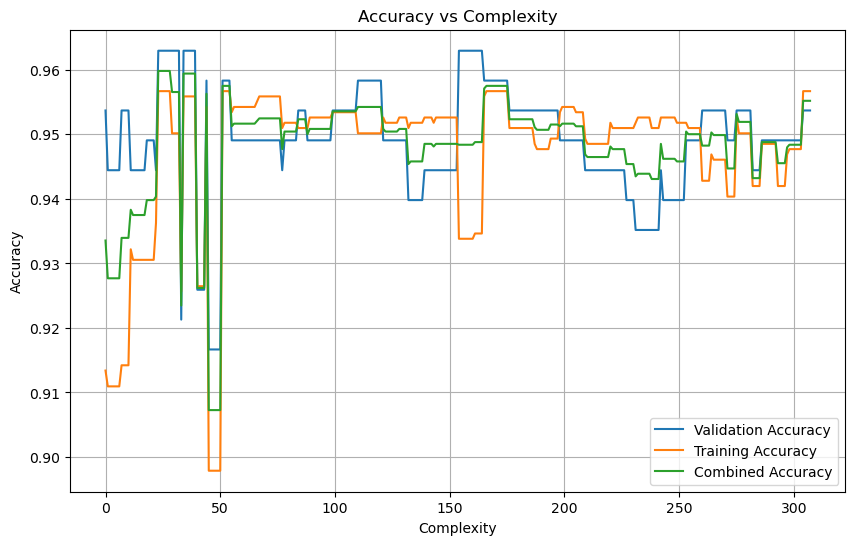

In [1711]:
components = np.arange(len(val_accuracy))  # X-axis: components (0, 1, 2,...)

plt.figure(figsize=(10, 6))
plt.plot(components, val_accuracy, label='Validation Accuracy')
plt.plot(components, train_accuracy, label='Training Accuracy')
plt.plot(components, combined_accuracy, label='Combined Accuracy')

# Adding titles and labels
plt.title('Accuracy vs Complexity')
plt.xlabel('Complexity')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [1744]:
index = val_accuracy.index(max(val_accuracy))

tfidf1 = TfidfVectorizer(min_df=min_arr[index], max_df = max_arr[index], norm = norm_arr[index], stop_words = 'english')
tfidf1_train = tfidf1.fit_transform(X_train_['Text'])

model = NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 101) 
W = model.fit_transform(tfidf1_train)
train_acc, label_map = label_permute_compare(y_train_,W,n=5)
print(f'train accuracy {train_acc}, label map: {label_map}')

tfidf1_val = tfidf1.transform(X_val_['Text'])  
W_val = model.transform(tfidf1_val) 
val_acc, label_map = label_permute_compare(y_val_, W_val, n=5)
print(f'validation accuracy: {val_acc}, label map: {label_map}')

train accuracy 0.9566993464052288, label map: {0: 'business', 3: 'entertainment', 2: 'politics', 1: 'sport', 4: 'tech'}
validation accuracy: 0.9629629629629629, label map: {0: 'business', 3: 'entertainment', 2: 'politics', 1: 'sport', 4: 'tech'}


In [1713]:
tfidf1_test = tfidf1.transform(test['Text'])  
W_test = model.transform(tfidf1_test) 

In [1714]:
yp = np.array([np.argmax(i) for i in W_test])

In [1715]:
print(yp)

[1 4 1 0 1 1 2 2 3 0 0 4 2 4 3 1 2 4 3 2 0 2 1 0 2 1 0 1 1 0 2 4 0 0 1 1 1
 0 3 2 4 2 3 4 1 4 3 0 2 0 2 0 0 0 4 2 4 3 1 4 1 3 4 2 0 3 1 4 1 1 4 1 0 2
 4 1 4 4 4 3 2 1 3 3 0 3 0 3 0 4 3 2 1 4 1 1 1 1 1 1 2 1 2 3 0 1 2 1 2 3 1
 0 3 1 2 1 2 1 2 0 3 0 3 3 4 1 0 3 0 3 0 2 2 4 0 0 2 4 3 1 0 4 1 3 2 1 1 3
 3 4 0 4 2 3 1 1 1 1 3 4 0 4 0 4 0 4 3 4 4 2 0 2 0 0 3 2 4 0 0 4 1 2 1 2 4
 4 2 0 2 3 2 0 3 1 4 4 0 4 2 0 1 2 0 3 0 0 1 4 0 1 3 3 1 3 1 4 2 3 1 3 1 3
 2 0 4 3 0 2 0 4 0 1 2 2 2 2 1 0 2 2 1 2 0 1 4 0 2 0 2 0 0 1 4 2 4 4 3 4 1
 1 4 1 1 1 3 1 2 4 0 1 0 1 0 1 3 0 0 3 2 0 1 1 4 1 1 3 0 1 4 2 3 0 0 2 1 3
 2 0 1 1 4 3 1 0 4 0 1 2 2 3 2 3 2 0 2 4 0 1 4 3 2 1 2 2 4 2 1 4 2 4 4 3 2
 4 2 0 2 1 4 3 3 0 1 4 4 3 4 0 1 3 4 0 2 4 4 2 2 1 0 4 1 2 2 0 4 1 2 0 2 2
 4 4 0 0 1 1 1 4 4 2 4 2 2 0 1 1 3 3 1 4 4 1 4 3 2 4 1 0 2 3 0 4 1 2 0 0 2
 4 1 3 0 4 0 4 4 1 2 0 4 1 2 0 4 4 2 4 0 2 0 3 0 3 2 3 1 0 2 0 1 3 0 3 3 1
 4 3 4 0 2 3 2 2 1 0 1 2 3 3 0 0 1 2 4 0 2 0 1 1 2 1 4 0 2 1 2 4 0 2 4 2 2
 3 4 1 1 2 0 4 2 1 1 3 0 

In [1666]:
test_sub = pd.DataFrame(columns=["ArticleId", "Category"])
test_sub["ArticleId"] = test.ArticleId
test_sub["Category"] = [label_map[l] for l in yp]
test_sub.to_csv("submission.csv", index=False)
print('test score:0.96054, 96%')

test score:0.96054, 96%


The test score was roughly 96%. I will see if I can beat this score using supervised models.

# 4. Supervised Learning Models
I will train various supervised models and pick the best one, based on the validation data, to use for predicting the test function.
For classification, I have chosen a decision tree model, a logistic regression model, a KNN  model, and an ensemble adaboost model.

The previous TF-IDF was optimized for the specific NMF model. I will just use a generic TF-IDF for these models to avoid longer document runtimes.

In [1836]:

tfidf1 = TfidfVectorizer(stop_words = 'english')
tfidf1_train = tfidf1.fit_transform(X_train_['Text'])
tfidf1_val = tfidf1.transform(X_val_['Text'])

__Decision Tree Classifier__

In [1837]:
clf = DecisionTreeClassifier(max_leaf_nodes=200,max_depth=300)
clf.fit(tfidf1_train, y_train_)
pred = clf.predict(tfidf1_val)
accuracy_score(y_val_, pred)

0.7916666666666666

__Logistic Regression__

In [1840]:
tfidf1_val = tfidf1.transform(X_val_['Text'])
model1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0, max_iter=1000)
model1.fit(tfidf1_train, y_train_)
pred = model1.predict(tfidf1_val)
accuracy_score(y_val_, pred)

0.9675925925925926

__KNN__

In [1844]:
neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(tfidf1_train, y_train_)
pred = neigh.predict(tfidf1_val)
accuracy_score(y_val_, pred)

0.9629629629629629

__ADA Boost w/ Decision Tree__

In [1850]:
weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
n_estimators = 300

adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    algorithm="SAMME",
    random_state=42,
).fit(tfidf1_train, y_train_)

In [1852]:
pred = adaboost_clf.predict(tfidf1_val)
accuracy_score(y_val_, pred)

0.9120370370370371

### The best model was the logistic regression model, so I will submit the test data and see if this performs better than NMF

In [1860]:
tfidf1_test = tfidf1.transform(X_test) 
model1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0, max_iter=1000)
model1.fit(tfidf1_train, y_train_)
pred = model1.predict(tfidf1_test)

In [1864]:
test_sup = pd.DataFrame(columns=["ArticleId", "Category"])
test_sup["ArticleId"] = test.ArticleId
test_sup["Category"] = pred
test_sup.to_csv("submission1.csv", index=False)
print('test score:0.98367, 98.3%')

test score:0.98367, 98.3%


In [1866]:
from tabulate import tabulate


data = [['AdaBoost','.912'],
       ['Decision Tree','.792'],
       ['KNN','.963'],
       ['Logistic Regression','.968'],
       ['Non-negative Matrix Factorization','.963']]
head = ['Method', 'Accuracy']

print(tabulate(data, headers=head, tablefmt="grid"))

+-----------------------------------+------------+
| Method                            |   Accuracy |
+===================================+============+
| AdaBoost                          |     0.912  |
+-----------------------------------+------------+
| Decision Tree                     |     0.9101 |
+-----------------------------------+------------+
| KNN                               |     0.963  |
+-----------------------------------+------------+
| Logistic Regression               |     0.968  |
+-----------------------------------+------------+
| Non-negative Matrix Factorization |     0.963  |
+-----------------------------------+------------+
